# **Exploratory Analysis**

## Importing Modules

In [ ]:
import tensorflow
import keras

from tensorflow.keras.layers import Conv2D, MaxPool2D, BatchNormalization, GlobalAveragePooling2D, AveragePooling2D, Activation
from tensorflow.keras.applications import Xception
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
import seaborn as sns
import os

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils import class_weight

## Mounting the Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Reading Image Dataset

In [ ]:
directory= f"/content/drive/My Drive/Project/train"
folderlist= os.listdir(directory)
print(folderlist)

['4', '3', '0', '1', '2']


In [ ]:
image_path_list = []
label_list = []
for folder in folderlist:
    image_list = os.listdir(f"{directory}/{folder}")
    image_path_list += [ f"{directory}/{folder}/"+ path for path in image_list]
    label_list += [folder] * len(image_list)

train = pd.DataFrame({"filepath" : image_path_list, "label": label_list})

In [ ]:
train

,filepath,label
0,/content/drive/My Drive/Project/train/4/967195...,4
1,/content/drive/My Drive/Project/train/4/910378...,4
2,/content/drive/My Drive/Project/train/4/948699...,4
3,/content/drive/My Drive/Project/train/4/911403...,4
4,/content/drive/My Drive/Project/train/4/939398...,4
...,...,...
5773,/content/drive/My Drive/Project/train/2/967623...,2
5774,/content/drive/My Drive/Project/train/2/982187...,2
5775,/content/drive/My Drive/Project/train/2/939460...,2
5776,/content/drive/My Drive/Project/train/2/952364...,2


In [ ]:
directory= f"/content/drive/My Drive/Project/test"
folderlist= os.listdir(directory)
image_path_list = []
label_list = []
for folder in folderlist:
    image_list = os.listdir(f"{directory}/{folder}")
    image_path_list += [ f"{directory}/{folder}/"+ path for path in image_list]
    label_list += [folder] * len(image_list)

test = pd.DataFrame({"filepath" : image_path_list, "label": label_list})

In [ ]:
test

,filepath,label
0,/content/drive/My Drive/Project/test/4/9284795...,4
1,/content/drive/My Drive/Project/test/4/9235666...,4
2,/content/drive/My Drive/Project/test/4/9387265...,4
3,/content/drive/My Drive/Project/test/4/9693806...,4
4,/content/drive/My Drive/Project/test/4/9086204...,4
...,...,...
821,/content/drive/My Drive/Project/test/1/9522615...,1
822,/content/drive/My Drive/Project/test/1/9560051...,1
823,/content/drive/My Drive/Project/test/1/9284909...,1
824,/content/drive/My Drive/Project/test/1/9222068...,1


In [ ]:
directory= f"/content/drive/My Drive/Project/val"
folderlist= os.listdir(directory)
image_path_list = []
label_list = []
for folder in folderlist:
    image_list = os.listdir(f"{directory}/{folder}")
    image_path_list += [ f"{directory}/{folder}/"+ path for path in image_list]
    label_list += [folder] * len(image_list)

val = pd.DataFrame({"filepath" : image_path_list, "label": label_list})

In [ ]:
val

,filepath,label
0,/content/drive/My Drive/Project/val/4/9012867R...,4
1,/content/drive/My Drive/Project/val/4/9775951L...,4
2,/content/drive/My Drive/Project/val/4/9886298L...,4
3,/content/drive/My Drive/Project/val/4/9541124L...,4
4,/content/drive/My Drive/Project/val/4/9448133L...,4
...,...,...
1651,/content/drive/My Drive/Project/val/2/9735251R...,2
1652,/content/drive/My Drive/Project/val/2/9426434L...,2
1653,/content/drive/My Drive/Project/val/2/9921329R...,2
1654,/content/drive/My Drive/Project/val/2/9828819L...,2


In [ ]:
test['label']=(test['label']).astype(int)
train['label']=(train['label']).astype(int)
val['label']=(val['label']).astype(int)

## Visualizing Class labels

Text(0, 0.5, 'count')

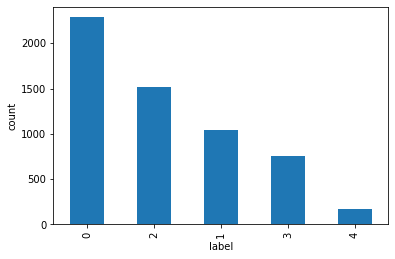

In [ ]:
train.label.value_counts().plot.bar()
plt.xlabel("label")
plt.ylabel("count")

Text(0, 0.5, 'count')

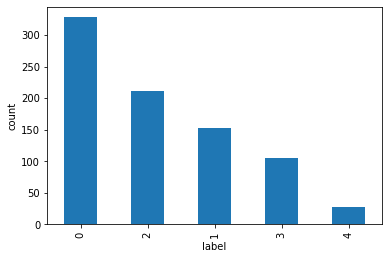

In [ ]:
test.label.value_counts().plot.bar()
plt.xlabel("label")
plt.ylabel("count")

Text(0, 0.5, 'count')

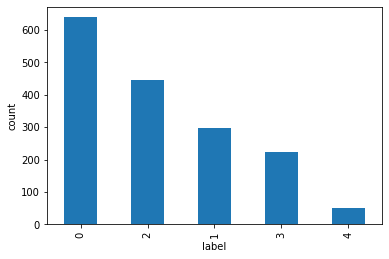

In [ ]:
val.label.value_counts().plot.bar()
plt.xlabel("label")
plt.ylabel("count")

## Data Augmentation for Train and Validation

In [ ]:
train_aug = ImageDataGenerator(rescale=1./255)
val_aug = ImageDataGenerator(rescale=1./255)
test_aug = ImageDataGenerator(rescale=1./255)

In [ ]:
train_generator = train_aug.flow_from_dataframe(
dataframe=train,
directory=None,
x_col="filepath",
y_col="label",
batch_size=32,
seed=42,
shuffle=True,
class_mode="raw",
target_size=(224,224))


Found 5778 validated image filenames.


In [ ]:
valid_generator = val_aug.flow_from_dataframe(
dataframe= val,
x_col= "filepath",
y_col= "label",
batch_size= 32,
seed= 42,
shuffle= True,
class_mode= "raw",
target_size= (224,224))

Found 1656 validated image filenames.


## Model Building

### Architecture

In [ ]:
xception = Xception(weights="imagenet",)
x= xception.layers[-3].output

x = Conv2D(filters= 1024, kernel_size= 3, padding= "same")(x)
x = BatchNormalization()(x)
x = Activation("relu")(x)

x = Conv2D(filters= 512, kernel_size= 3, padding= "same")(x)
x = BatchNormalization()(x)
x = Activation("relu")(x)

x = Conv2D(filters= 256, kernel_size= 3, padding= "same")(x)
x = BatchNormalization()(x)
x = Activation("relu")(x)

x = Conv2D(filters= 64, kernel_size= 3, padding= "same")(x)
x = BatchNormalization()(x)
x = Activation("relu")(x)

x = Conv2D(filters= 32, kernel_size= 3, padding= "same")(x)
x = BatchNormalization()(x)
x = Activation("relu")(x)

x = Conv2D(filters= 5, kernel_size= 3, padding= "same")(x)
x = BatchNormalization()(x)
x = Activation("softmax")(x)

GAP = GlobalAveragePooling2D()(x)
pred = tensorflow.keras.activations.softmax(GAP)

model = Model(inputs=xception.input,outputs=pred)

91897856/91884032 [==============================] - 1s 0us/step


In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 149, 149, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                             

### Compilation

In [ ]:
model.compile(optimizer = Adam(learning_rate=0.00001,decay=0.0001),loss= 'sparse_categorical_crossentropy',metrics = ['acc'])

### Checkpoints, Early Stopping and Reduce LR on Plateau

In [ ]:
checkpoint_dir = os.path.dirname('/content/drive/MyDrive/Project')
my_callbacks = [
ModelCheckpoint('/content/drive/MyDrive/Project', monitor = 'val_acc',verbose = 1,save_weights_only=True, save_best_only = True,mode="max"),
EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='min'),
ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1, mode='min',min_delta=1e-4)
]

### Class Weights

In [ ]:
class_weights = class_weight.compute_class_weight('balanced',
classes= np.unique(train.label.values),
y= train.label.values)
class_weights = dict(enumerate(class_weights))

In [ ]:
class_weights

{0: 0.5055118110236221,
 1: 1.1047801147227534,
 2: 0.7622691292875989,
 3: 1.5265521796565389,
 4: 6.679768786127168}

### Fitting the Model

In [ ]:
model.fit(
        train_generator,
        epochs=40,
        validation_data=valid_generator,
        callbacks=[my_callbacks],
        class_weight=class_weights)

Epoch 1/40
305/305 [==============================] - 163s 497ms/step - loss: 1.5368 - acc: 0.2719 - val_loss: 1.6770 - val_acc: 0.2413

Epoch 00001: val_acc improved from -inf to 0.24129, saving model to training_0/cp.ckpt
Epoch 2/40
305/305 [==============================] - 148s 486ms/step - loss: 1.2195 - acc: 0.4472 - val_loss: 1.4489 - val_acc: 0.4070

Epoch 00002: val_acc improved from 0.24129 to 0.40702, saving model to training_0/cp.ckpt
Epoch 3/40
305/305 [==============================] - 148s 486ms/step - loss: 1.0700 - acc: 0.5509 - val_loss: 1.2610 - val_acc: 0.5283

Epoch 00003: val_acc improved from 0.40702 to 0.52830, saving model to training_0/cp.ckpt
Epoch 4/40
305/305 [==============================] - 149s 487ms/step - loss: 0.9554 - acc: 0.6199 - val_loss: 1.1081 - val_acc: 0.6450

Epoch 00004: val_acc improved from 0.52830 to 0.64498, saving model to training_0/cp.ckpt
Epoch 5/40
305/305 [==============================] - 148s 487ms/step - loss: 0.8615 - acc: 0.6

## Data Augmentation for Test

In [ ]:
test_gen = test_aug.flow_from_dataframe(dataframe= test,
                            x_col= "filepath",
                            y_col= "label",
                            class_mode=None,
                            target_size= (299, 299),
                            shuffle= False,
                            batch_size= 1
                            )

Found 826 validated image filenames.


## Predicting the model

In [ ]:
pred=model.predict(test_gen)

## Confusion Matrix

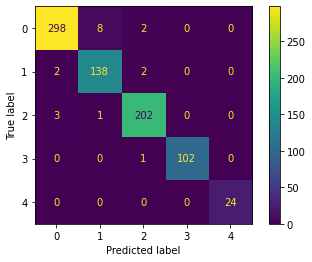

In [ ]:
predtest =  np.argmax(pred, axis= 1)
cm = confusion_matrix(test.label, predtest, labels=[0, 1, 2, 3, 4])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1, 2, 3, 4])
disp.plot()